In [121]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams.update({'font.size':16})

In [122]:
#openai's example
import re

# Example usage with capturing groups in alternation:
input_string = "The color of the car is either blue."
match = re.search(r'The color of the car is either (red|blue)\.', input_string)

if match:
    color = match.group(1)
    print("Car color:", color)
else:
    print("No match found.")

Car color: blue


In [123]:
relitive_path = "data\\"
file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
shots= ["8","13","14","37","39"]

filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", file_name))]
shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]

shot_no

[13, 14, 8]

In [124]:
######## FUNCTIONS #########

def read_data(shot, silent= False):
    ###FIND MATCHING FILE NAMES
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    kirills_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT"+ str(shot) + "[^0-9]*[0-9]{3}[^0-9].*.csv", file_name))]
    phils_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*{:d}[^0-9]*\.csv".format(shot) , file_name))]
    xray_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT{:d}.tif".format(shot) , file_name))]
    filtered_file_names = kirills_file_names + phils_file_names + xray_file_names
    ###PRINT FILE INFO
    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]
    ###PUT OSCILLOSCOPE FILES INTO DICTIONARY
    dictionary = {}
    for phils_file_name in phils_file_names: # should only be 1 file
        for n, column in enumerate(["time","bdot","tof","diode"]): # some data files have Ch4 but it's just noise.
            dictionary[column] = np.genfromtxt(relitive_path+phils_file_name, delimiter=',', skip_header =18, usecols=n)
    ###PUT THZ FILES INTO DICTIONARY
    for kirill_file_name in kirills_file_names: # should only be 2 files
        for Ch in ["Ch1","Ch2","Ch3","Ch4"]:
            if Ch in kirill_file_name : channel = Ch # Python has got some weird ways of writing if statements.
        dictionary["pyro_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    ###PUT XRAY FILES INTO DICTIONARY
    for xray_file_name in xray_file_names: # should only be 2 files
        raw = "_raw" if "raw" in xray_file_name else ""
        dictionary["xray" + raw] = np.array(Image.open(relitive_path+xray_file_name))

    return dictionary

def read_lots_of_data(shots, requested_data, silent= False): #read_data is too slow because it reads all files. Sorry that this is messy. The're a lot of regex codes and list comprehentions.
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    shots = np.array([str(shot) for shot in shots])
    dictionary = {}
    oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    if requested_data in pyro_data:
        channel = "Ch1" if requested_data == "pyro_time" else requested_data
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4)

    elif requested_data in oscilloscope_data:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", file_name))]
        shot_no = [int(re.search("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            column = oscilloscope_data.index(requested_data)
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =18, usecols= column)

    elif requested_data in ["xray", "xray_raw"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+").tif", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+").tif", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        raw = [True if "raw" in filtered_file_name else False for filtered_file_name in filtered_file_names]
        if requested_data == "xray":
            filtered_file_names = np.array(filtered_file_names)[np.logical_not(raw)]
            shot_no = np.array(shot_no)[np.logical_not(raw)]
        else:
            filtered_file_names = np.array(filtered_file_names)[raw]
            shot_no = np.array(shot_no)[raw]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.array(Image.open(relitive_path+filtered_file_names[n]))

    elif requested_data == "espec":
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("^IP.*.tif", file_name))]
        #shot number = N/A
        for filtered_file_name in filtered_file_names: # Should be all files as the espec is related to a set of shots as opposed to a single shot.
            dictionary[filtered_file_name] = np.array(Image.open(relitive_path+filtered_file_name))

    else:
        raise ValueError("{0:} is not a recognised data set".format(requested_data))

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return dictionary # dict with the shot number as keys :)


In [140]:
especs = read_lots_of_data([], "espec")
espec = list(especs.values())[0]

###How should I crop it?

Found 2 files:
   IP_26012024.tif
   IP_26012024_scan2.tif


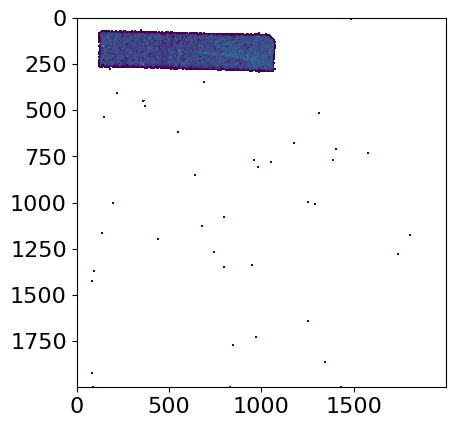

In [139]:
plt.imshow(espec, norm= "log")
plt.show()

In [125]:
shot_max = 75

In [128]:
xrays = read_lots_of_data(np.arange(shot_max), "xray", silent= True)
xray_max = [np.max(xray) for xray in xrays.values()]
xray_shot_no = list(xrays.keys())

bdots = read_lots_of_data(np.arange(shot_max), "bdot", silent= True)
bdot_max = [np.max(bdot) for bdot in bdots.values()]
bdot_shot_no = list(bdots.keys())

pyros = read_lots_of_data(np.arange(shot_max), "Ch2", silent= True)
pyro_max = [np.max(pyro) for pyro in pyros.values()]
pyro_shot_no = list(pyros.keys())

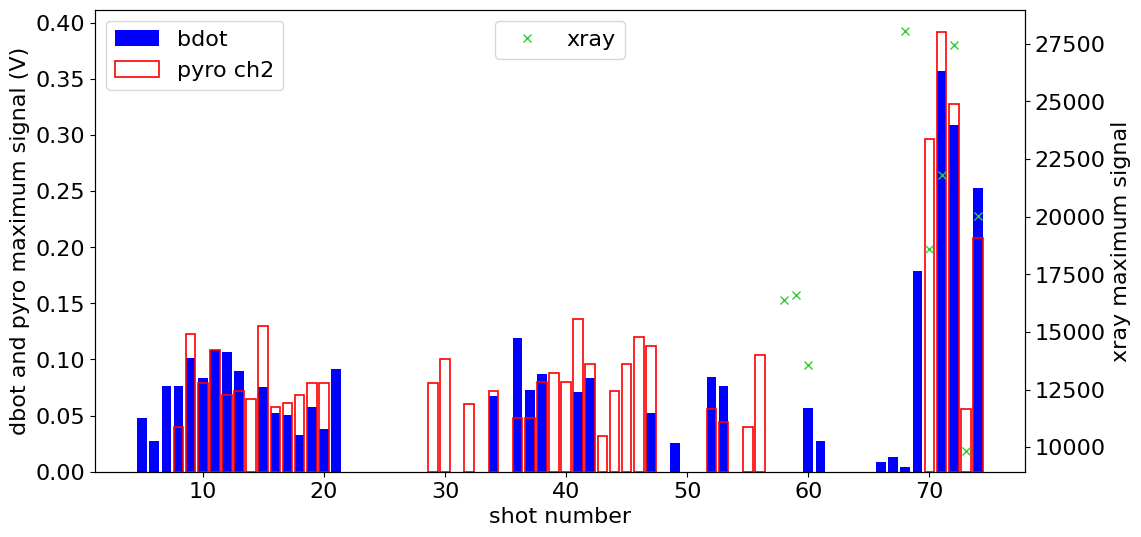

In [133]:
fig, axs = plt.subplots(figsize= (12,6))

axs.bar(bdot_shot_no, bdot_max, color="blue", label= "bdot")
axs.bar(pyro_shot_no, pyro_max, edgecolor='red', color='none', linewidth= 1.2, label= "pyro ch2")
axs.set(xlabel= "shot number", ylabel= "dbot and pyro maximum signal (V)")
plt.legend(loc= "upper left")

twin = axs.twinx()

twin.plot(xray_shot_no, xray_max, linestyle= "None", marker= "x", color= "limegreen", label= "xray")
twin.set(ylabel= "xray maximum signal")

plt.legend(loc= "upper center")
plt.show()

Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv
Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv


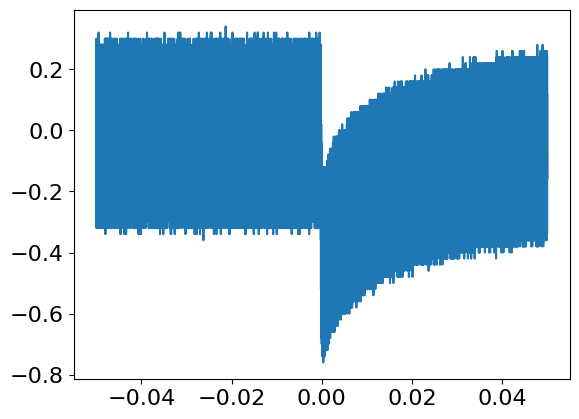

In [130]:
array_time = read_data(8)["pyro_time"]
array_data = read_data(8)["Ch1"]
plt.plot(array_time, array_data)
plt.show()